In [26]:
image_size = 256

In [1]:
import os
import glob
import pydicom
import nibabel as nib
import pandas as pd
import numpy as np
from pydicom.pixel_data_handlers.util import apply_voi_lut
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import seaborn as sns

from tqdm import tqdm

from PIL import Image, ImageOps

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision.io import read_image
import torchvision.transforms as T
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, CenterCrop
import torchvision.transforms.functional as TF
import torchvision.models as models

In [29]:
DATA_DIR = "/Volumes/SSD970/"
TRAIN_IMAGES_DIR = os.path.join(DATA_DIR, "train_images")

TRAIN_CORONAL_IMAGES_DIR = os.path.join(DATA_DIR, "train_coronal_images")
TRAIN_CORONAL_LABEL_DIR = os.path.join(DATA_DIR, "train_coronal_labels")
TRAIN_SAGITTAL_IMAGES_DIR = os.path.join(DATA_DIR, "train_sagittal_images_jpeg95")
TRAIN_SAGITTAL_LABEL_DIR = os.path.join(DATA_DIR, "train_sagittal_labels_jpeg95")

In [3]:
bbox_df = pd.read_csv(os.path.join(DATA_DIR, 'bbox_clean.csv'))
bbox_df["UID"] = bbox_df["StudyInstanceUID"]
bbox_df = bbox_df.set_index("UID")

# bbox_df.loc[[
#     "1.2.826.0.1.3680043.8362",
#     "1.2.826.0.1.3680043.8858",
#     "1.2.826.0.1.3680043.20574",
#     "1.2.826.0.1.3680043.20756",
#     "1.2.826.0.1.3680043.23400",
#     "1.2.826.0.1.3680043.29630",
#     "1.2.826.0.1.3680043.29952",
# ]].drop()

bbox_df.head()

,StudyInstanceUID,start_slice_number,axial_index,coronal_index,sagittal_index,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number
UID,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,132,226,227,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,133,229,230,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,134,234,230,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,135,234,228,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,136,237,227,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137


In [4]:
bbox_df["StudyInstanceUID"].isnull().any()

False

In [5]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
train_df["UID"] = train_df["StudyInstanceUID"]
train_df = train_df.set_index("UID")
train_df.head()

,StudyInstanceUID,patient_overall,C1,C2,C3,C4,C5,C6,C7
UID,,,,,,,,,
1.2.826.0.1.3680043.6200,1.2.826.0.1.3680043.6200,1,1,1,0,0,0,0,0
1.2.826.0.1.3680043.27262,1.2.826.0.1.3680043.27262,1,0,1,0,0,0,0,0
1.2.826.0.1.3680043.21561,1.2.826.0.1.3680043.21561,1,0,1,0,0,0,0,0
1.2.826.0.1.3680043.12351,1.2.826.0.1.3680043.12351,0,0,0,0,0,0,0,0
1.2.826.0.1.3680043.1363,1.2.826.0.1.3680043.1363,1,0,0,0,0,1,0,0


In [6]:
pos_df = pd.read_csv(os.path.join(DATA_DIR, 'infer_sagittal_position.csv')).set_index('UID')
pos_df.head()

,direction,sagittal_index,bottom,right,top,left,z_spacing,pixel_spacing,aspect,width,height,coronal_left,coronal_top,coronal_right,coronal_bottom,sagittal_left,sagittal_top,sagittal_right,sagittal_bottom
UID,,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10001,2,88,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,89,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,90,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,91,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10001,2,92,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213


In [7]:
pos_df.index

Index(['1.2.826.0.1.3680043.10001', '1.2.826.0.1.3680043.10001',
       '1.2.826.0.1.3680043.10001', '1.2.826.0.1.3680043.10001',
       '1.2.826.0.1.3680043.10001', '1.2.826.0.1.3680043.10001',
       '1.2.826.0.1.3680043.10001', '1.2.826.0.1.3680043.10001',
       '1.2.826.0.1.3680043.10001', '1.2.826.0.1.3680043.10001',
       ...
       '1.2.826.0.1.3680043.9997', '1.2.826.0.1.3680043.9997',
       '1.2.826.0.1.3680043.9997', '1.2.826.0.1.3680043.9997',
       '1.2.826.0.1.3680043.9997', '1.2.826.0.1.3680043.9997',
       '1.2.826.0.1.3680043.9997', '1.2.826.0.1.3680043.9997',
       '1.2.826.0.1.3680043.9997', '1.2.826.0.1.3680043.9997'],
      dtype='object', name='UID', length=556697)

In [8]:
pos_df = pos_df.reset_index().drop_duplicates(subset='UID').set_index('UID')
pos_df.head()

,direction,sagittal_index,bottom,right,top,left,z_spacing,pixel_spacing,aspect,width,height,coronal_left,coronal_top,coronal_right,coronal_bottom,sagittal_left,sagittal_top,sagittal_right,sagittal_bottom
UID,,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10001,2,88,590,377,98,49,0.625,0.253906,2.461541,512,659,74,54,185,213,58,54,164,213
1.2.826.0.1.3680043.10005,2,103,291,366,0,22,0.625,0.298828,2.091504,512,541,66,10,172,142,31,9,166,126
1.2.826.0.1.3680043.10014,2,55,882,480,148,28,0.800,0.234000,3.418803,512,882,79,61,170,239,73,61,182,239
1.2.826.0.1.3680043.10016,2,101,601,396,98,37,0.313,0.275391,1.136566,512,733,83,49,176,192,62,49,166,195
1.2.826.0.1.3680043.10032,2,100,584,413,125,28,0.625,0.320313,1.951216,512,626,74,68,168,223,48,67,179,223


In [9]:
def get_padded_position(size, pos, reshape_size=256):
    h, w = size
    pad = int((max(size) - min(size)) // 2)
    x, y = pos
    if h > w:
        x = pad + x
    else:
        y = pad + y
    scale = reshape_size / max(size)
    return int(x * scale), int(y * scale)

get_padded_position([200, 400], [200, 100])

(128, 128)

In [10]:
bbox_df.iloc[0]

StudyInstanceUID      1.2.826.0.1.3680043.10051
start_slice_number                            1
axial_index                                 132
coronal_index                               226
sagittal_index                              227
aspect                                 2.461541
pixel_spacing                          0.253906
z_spacing                                 0.625
is_flip                                     0.0
num_slices                                  272
x                                     219.27715
y                                     216.71419
width                                   17.3044
height                                 20.38517
slice_number                                133
Name: 1.2.826.0.1.3680043.10051, dtype: object

In [11]:
pos_df.loc[bbox_df.iloc[0].name]

direction            2.000000
sagittal_index      58.000000
bottom             606.000000
right              416.000000
top                 47.000000
left                48.000000
z_spacing            0.625000
pixel_spacing        0.253906
aspect               2.461541
width              512.000000
height             669.000000
coronal_left        63.000000
coronal_top         36.000000
coronal_right      169.000000
coronal_bottom     214.000000
sagittal_left       60.000000
sagittal_top        36.000000
sagittal_right     177.000000
sagittal_bottom    214.000000
Name: 1.2.826.0.1.3680043.10051, dtype: float64

(512, 669)


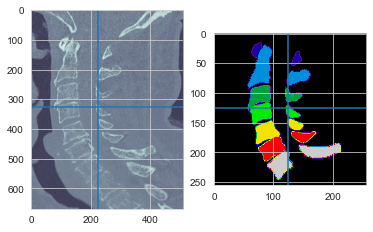

In [12]:
def get_sagittal_center_position(s):
    """
    center position w.r.t cropped label image
    이것으로써 bbox 가 sagittal image 에서 C? 을 말해주는가 알 수 있다.
    C? 이 classification label 가 되겠다.
    :param s:
    :return:
    """
    y, x = np.round(s.axial_index * s.aspect), s.coronal_index # row, column
    UID = s["StudyInstanceUID"]
    if UID in pos_df.index:
        left, top, right, bottom = pos_df.loc[UID, ['left','top','right','bottom']]
    else:
        print(f"{UID} not in index")
        return
    # print([left, top, right, bottom])
    y -= left
    x -= top

    padded_pos = get_padded_position([bottom - top, right - left], [x, y])
    return padded_pos

sagittal_df = bbox_df.iloc[0]
UID = sagittal_df.name
img = Image.open(os.path.join(DATA_DIR, 'train_sagittal_labels_jpeg95', UID, f"{int(sagittal_df.sagittal_index)}.png"))
x, y = get_sagittal_center_position(sagittal_df)
_, axs = plt.subplots(1, 2)

original_img = Image.open(os.path.join(DATA_DIR, 'train_sagittal_images_jpeg95', UID, f"{int(sagittal_df.sagittal_index)}.jpeg"))
print(original_img.size)
axs[0].imshow(original_img, cmap='bone')
axs[0].axvline(sagittal_df.coronal_index)
axs[0].axhline(np.round(sagittal_df.axial_index * sagittal_df.aspect))

axs[1].imshow(img, cmap='nipy_spectral')
axs[1].axvline(x)
axs[1].axhline(y)

In [13]:
sagittal_df

StudyInstanceUID      1.2.826.0.1.3680043.10051
start_slice_number                            1
axial_index                                 132
coronal_index                               226
sagittal_index                              227
aspect                                 2.461541
pixel_spacing                          0.253906
z_spacing                                 0.625
is_flip                                     0.0
num_slices                                  272
x                                     219.27715
y                                     216.71419
width                                   17.3044
height                                 20.38517
slice_number                                133
Name: 1.2.826.0.1.3680043.10051, dtype: object

In [14]:
bbox_df.insert(2, 'sagittal_label_x', None)
bbox_df.insert(2, 'sagittal_label_y', None)
bbox_df.head()

,StudyInstanceUID,start_slice_number,sagittal_label_y,sagittal_label_x,axial_index,coronal_index,sagittal_index,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number
UID,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,None,None,132,226,227,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,None,None,133,229,230,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,None,None,134,234,230,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,None,None,135,234,228,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,None,None,136,237,227,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137


In [15]:
bbox_df = bbox_df.reset_index()
bbox_df.head()

,UID,StudyInstanceUID,start_slice_number,sagittal_label_y,sagittal_label_x,axial_index,coronal_index,sagittal_index,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,None,None,132,226,227,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,None,None,133,229,230,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,None,None,134,234,230,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,None,None,135,234,228,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,None,None,136,237,227,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137


In [16]:
bbox_df

,UID,StudyInstanceUID,start_slice_number,sagittal_label_y,sagittal_label_x,axial_index,coronal_index,sagittal_index,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,None,None,132,226,227,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,None,None,133,229,230,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,None,None,134,234,230,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,None,None,135,234,228,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,None,None,136,237,227,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7198,1.2.826.0.1.3680043.9940,1.2.826.0.1.3680043.9940,1,None,None,139,148,339,2.666667,0.234375,0.625,0.0,259,297.23186,115.53983,85.18228,66.52623,140
7199,1.2.826.0.1.3680043.9940,1.2.826.0.1.3680043.9940,1,None,None,140,147,341,2.666667,0.234375,0.625,0.0,259,298.00000,117.00000,86.00000,61.00000,141
7200,1.2.826.0.1.3680043.9940,1.2.826.0.1.3680043.9940,1,None,None,141,148,341,2.666667,0.234375,0.625,0.0,259,298.00000,119.00000,87.00000,58.00000,142
7201,1.2.826.0.1.3680043.9940,1.2.826.0.1.3680043.9940,1,None,None,142,148,343,2.666667,0.234375,0.625,0.0,259,299.00000,120.00000,89.00000,56.00000,143


In [19]:
for i in tqdm(range(len(bbox_df))):
    sagittal_df = bbox_df.iloc[i]
    x, y = get_sagittal_center_position(sagittal_df)
    # label_img = Image.open(os.path.join(DATA_DIR, 'train_sagittal_labels_jpeg95', UID, f"{int(sagittal_df.sagittal_index)}.png"))
    bbox_df.loc[i, ['sagittal_label_x', 'sagittal_label_y']] = x, y
bbox_df = bbox_df.set_index('UID')
bbox_df.head()

100%|██████████| 7203/7203 [00:09<00:00, 727.19it/s]


,UID,StudyInstanceUID,start_slice_number,sagittal_label_y,sagittal_label_x,axial_index,coronal_index,sagittal_index,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,126,125,132,226,227,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,127,126,133,229,230,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,129,129,134,234,230,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,130,129,135,234,228,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,131,130,136,237,227,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137


In [21]:
bbox_df.head()

,StudyInstanceUID,start_slice_number,sagittal_label_y,sagittal_label_x,axial_index,coronal_index,sagittal_index,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number
UID,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,126,125,132,226,227,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,127,126,133,229,230,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,129,129,134,234,230,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,130,129,135,234,228,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,131,130,136,237,227,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137


In [23]:
bbox_df.insert(2, 'left', None)
bbox_df.insert(2, 'top', None)
bbox_df.insert(2, 'right', None)
bbox_df.insert(2, 'bottom', None)
bbox_df.head()

,StudyInstanceUID,start_slice_number,bottom,right,top,left,sagittal_label_y,sagittal_label_x,axial_index,coronal_index,...,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number
UID,,,,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,None,None,None,None,126,125,132,226,...,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,None,None,None,None,127,126,133,229,...,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,None,None,None,None,129,129,134,234,...,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,None,None,None,None,130,129,135,234,...,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,None,None,None,None,131,130,136,237,...,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137


In [24]:
for UID in tqdm(bbox_df.index.values):
    bbox_df.loc[UID, ['left','top','right','bottom']] = pos_df.loc[UID, ['left','top','right','bottom']].values

In [25]:
bbox_df.head()

,StudyInstanceUID,start_slice_number,bottom,right,top,left,sagittal_label_y,sagittal_label_x,axial_index,coronal_index,...,aspect,pixel_spacing,z_spacing,is_flip,num_slices,x,y,width,height,slice_number
UID,,,,,,,,,,,,,,,,,,,,,
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,606.0,416.0,47.0,48.0,126,125,132,226,...,2.461541,0.253906,0.625,0.0,272,219.27715,216.71419,17.30440,20.38517,133
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,606.0,416.0,47.0,48.0,127,126,133,229,...,2.461541,0.253906,0.625,0.0,272,221.56460,216.71419,17.87844,25.24362,134
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,606.0,416.0,47.0,48.0,129,129,134,234,...,2.461541,0.253906,0.625,0.0,272,216.82151,221.62546,27.00959,26.37454,135
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,606.0,416.0,47.0,48.0,130,129,135,234,...,2.461541,0.253906,0.625,0.0,272,214.49455,215.48637,27.92726,37.51363,136
1.2.826.0.1.3680043.10051,1.2.826.0.1.3680043.10051,1,606.0,416.0,47.0,48.0,131,130,136,237,...,2.461541,0.253906,0.625,0.0,272,214.00000,215.48637,27.00000,43.51363,137


In [27]:
# bbox_df.to_csv('train_bbox_sagittal_classification.csv')

(256, 256)
256
127 126


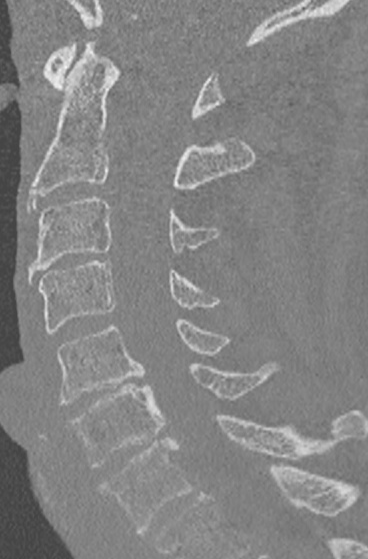

In [67]:
class SagittalDataset(Dataset):
    def __init__(self, df, image_dir, mask_dir, image_size=256, transform=None):
        super().__init__()

        self.df = df
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_size = image_size
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        s = self.df.iloc[idx]
        UID = s.name
        img = Image.open(os.path.join(self.image_dir, UID, f"{int(s.sagittal_index)}.jpeg"))
        img = TF.crop(img, s.top, s.left, s.bottom - s.top, s.right - s.left)

        mask = Image.open(os.path.join(self.mask_dir, UID, f"{int(s.sagittal_index)}.png"))
        mask = np.asarray(mask)
        print(mask.shape)
        print(self.image_size)
        row = np.clip(s.sagittal_label_y, a_min=0, a_max=(self.image_size-1))
        column = np.clip(s.sagittal_label_x, a_min=0, a_max=(self.image_size-1))
        print(row, column)
        label = mask[row, column] / 32
        if self.transform:
            img, mask, label = self.transform(img, mask, label)

        return img, mask, label

dataset = SagittalDataset(bbox_df, TRAIN_SAGITTAL_IMAGES_DIR, TRAIN_SAGITTAL_LABEL_DIR)
img, mask, label = dataset[1]
img

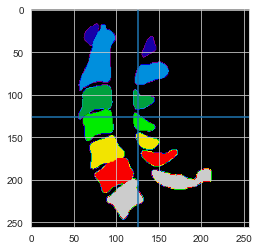

In [59]:
plt.imshow(mask, cmap="nipy_spectral")
plt.axhline(126)
plt.axvline(125)

In [60]:
label

0.5

## Transform

In [79]:
class DataTransform(nn.Module):
    def __init__(self, image_size):
        super().__init__()

        self.transform = T.Compose([
            T.Resize(image_size),
            T.RandomAutocontrast(),
            T.ToTensor(),
            T.Normalize(0.5, 0.5)
        ])

        # self.mask_transform = T.Normalize(0, 32)

        self.label_transform = T.ToTensor()

    def forward(self, x, mask, label):
        x = TF.center_crop(x, max(x.width, x.height))
        x = self.transform(x)

        # print(mask)
        mask = torch.tensor(mask, dtype=torch.float) / 32.
        mask = mask
        # mask = self.mask_transform(mask)

        label = torch.tensor(label, dtype=torch.float)
        return x, mask, label
transform = DataTransform(image_size)

In [80]:
dataset = SagittalDataset(bbox_df, TRAIN_SAGITTAL_IMAGES_DIR, TRAIN_SAGITTAL_LABEL_DIR, transform=transform)
img, mask, label = dataset[1]
mask.max()

(256, 256)
256
127 126


tensor(0.8750)

In [82]:
mask.shape

torch.Size([256, 256])

In [89]:
(torch.randn((2, 1, 3, 4, 4)) * torch.randn((7, 1, 1, 1))).shape

torch.Size([2, 7, 3, 4, 4])

In [111]:
mf = ((torch.arange(7) + 1) * 0.125).reshape(7, 1, 1)
print(mf)
print(mf.shape)
mask[mask == 0] = -torch.inf
mf = mf - mask.unsqueeze(0)
mf = mf ** 2
mf.shape

tensor([[[0.1250]],

        [[0.2500]],

        [[0.3750]],

        [[0.5000]],

        [[0.6250]],

        [[0.7500]],

        [[0.8750]]])
torch.Size([7, 1, 1])


torch.Size([7, 256, 256])

In [114]:
mf.unique()

tensor([0.0000, 0.0156, 0.0625, 0.1406, 0.2500, 0.3906, 0.5625,    inf])

In [124]:
dw = 10
mask_feature = torch.exp(-dw * mf)

In [130]:
mask_feature[6, :, :].unique()

tensor([0.0000, 0.0036, 0.0201, 0.0821, 0.2451, 0.5353, 0.8553, 1.0000])

In [12]:
def get_backbone():
    backbone = models.resnet50(pretrained=True)
    conv1_weight = backbone.conv1.weight
    conv1_weight = conv1_weight.mean(dim=1).unsqueeze(1)

    backbone.conv1 = nn.Conv2d(1, 64, kernel_size=(7, 7), stride=1, padding='same', bias=False)
    backbone.conv1.weight = nn.Parameter(conv1_weight, requires_grad=True)

    return nn.ModuleList([
        nn.Sequential(
            backbone.conv1,
            backbone.bn1,
            backbone.relu,
            backbone.maxpool),
        nn.Sequential(
            backbone.layer1,
            backbone.layer2,
        ),
        backbone.layer3,
        backbone.layer4
    ]), [1, 64, 512, 1024, 2048]

backbone, channels = get_backbone()
print(backbone)

/Users/longyikim/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/longyikim/anaconda3/envs/pytorch/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


ModuleList(
  (0): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(1, 1), padding=same, bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
        

In [13]:
backbone[0](torch.randn(1, 1, 256, 256)).shape

torch.Size([1, 64, 128, 128])

In [10]:
def print_list_shape(list):
    for i, l in enumerate(list):
        print(f"{i} {l.shape}")

In [24]:
class ClassificationModel(nn.Module):
    def __init__(self, backbone, channels, deep=4):
        super().__init__()

        self.backbone = backbone
        self.deep = deep
        self.channels = channels

        self.dw = nn.Parameter(torch.tensor(10.0, dtype=torch.float), requires_grad=True)

        self.init_layers()

    def init_layers(self):
        self.parallel_modules_1 = self.make_parallel_modules()
        self.parallel_modules_2 = self.make_parallel_modules()
        self.downsampling_modules = self.make_downsampling_modules()
        self.mask_modules = self.make_mask_modules()
        self.classification_modules = self.make_classification_modules()

    def make_parallel_modules(self):
        parallel_modules = nn.ModuleList()

        for channel in self.channels:
            module = nn.Conv2d(channel, channel, kernel_size=3, padding='same')
            parallel_modules.append(module)

        return parallel_modules

    def make_mask_modules(self):
        mask_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.Conv2d(self.channels[i], self.channels[i+1], kernel_size=3, stride=2, padding=1),
                nn.Sigmoid()
            )
            mask_modules.append(module)

        return mask_modules

    def make_downsampling_modules(self):
        downsampling_modules = nn.ModuleList()

        for i in range(self.deep):
            module = nn.Sequential(
                nn.ReLU(),
                nn.Conv2d(self.channels[i], self.channels[i+1], kernel_size=3, stride=2, padding=1),
            )
            downsampling_modules.append(module)

        return downsampling_modules

    def make_classification_modules(self):
        return nn.Sequential(
            nn.ReLU(),
            nn.Conv2d(self.channels[-1], self.channels[-1], kernel_size=3, padding='same'),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(self.channels[-1] * 16 * 16, 1)
        )

    def forward_recursive(self, x, modules):
        result = []
        out = x
        for module in modules:
            out = module(out)
            result.append(out)

        return result

    def forward_parallel(self, inputs, modules):
        result = []
        for input, module in zip(inputs, modules):
            out = module(input)
            result.append(out)

        return result

    def apply_mask(self, inputs, masks):
        result = []

        for input, mask in zip(inputs, masks):
            out = input * mask
            result.append(out)

        return result

    def repeat_mask(self, mask):
        N, H, W = mask.shape
        mask[mask == 0] = -torch.inf
        mf = ((torch.arange(7) + 1) * 0.125).reshape(7, 1, 1)
        mask = (mask.unsqueeze(1) - mf) ** 2
        mask = torch.exp(-self.dw * mask)  # N, 7, H, W
        mask = mask.reshape(-1, 1, H, W)
        return mask

    def forward_downsampling(self, features, modules):
        out = features[0]
        for i, module in enumerate(modules):
            out = module(out) + features[i + 1]

        return out

    def forward(self, x, mask):
        backbone_features = self.forward_recursive(x, self.backbone)

        mask = self.repeat_mask(mask)   # 14, 1, 256, 256
        mask_features = self.forward_recursive(mask, self.mask_modules)

        parallel_features_1 = self.forward_parallel([x] + backbone_features, self.parallel_modules_1)
        # 여기서 뻥튀기를 시킨다.
        parallel_features_1 = [feature.repeat_interleave(7, dim=0) for feature in parallel_features_1]

        masked_features = self.apply_mask(parallel_features_1, [mask] + mask_features)

        out = self.forward_parallel(masked_features, self.parallel_modules_2)

        out = self.forward_downsampling(out, self.downsampling_modules)
        out = self.classification_modules(out)

        return out


model = ClassificationModel(backbone, channels)

total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(total_params)

input = torch.randn(2, 1, 256, 256)
mask = torch.randn(2, 256, 256)
logits = model(input, mask)
logits.shape

208732502


torch.Size([14, 1])

In [16]:
(model.mask_modules[0](torch.randn(2, 1, 256, 256))).shape

torch.Size([2, 64, 126, 126])

In [17]:
model.mask_modules[0]

Sequential(
  (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(1, 1))
  (1): Sigmoid()
)